# 手写数字分类与全连接模型

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 预处理数据

In [2]:
# 导入torchvision库
from torchvision import datasets, transforms
# 定义一个转换函数，将图像转换为张量（Tensor）
transformation = transforms.Compose([
                                transforms.ToTensor(),  # transforms.ToTensor()会将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
                                # transforms.Normalize((0.5,), (0.5,))  # transforms.Normalize()会将图像的像素值进行标准化，即将像素值减去均值，然后除以标准差
])

# 从datasets模块中导入MNIST数据集
# 训练集
train_ds = datasets.MNIST(
                          # 数据集的存储路径
                          'dataset/',
                          # 是否为训练集
                          train=True,
                          # 数据集的转换函数
                          transform=transformation,
                          # 是否下载数据集
                          download=True  
)
# 测试集
test_ds = datasets.MNIST(
                          'dataset/',
                          train=False,
                          transform=transformation,
                          download=True  
)

In [3]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

## 熟悉数据集

torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
(28, 28)
tensor(7)


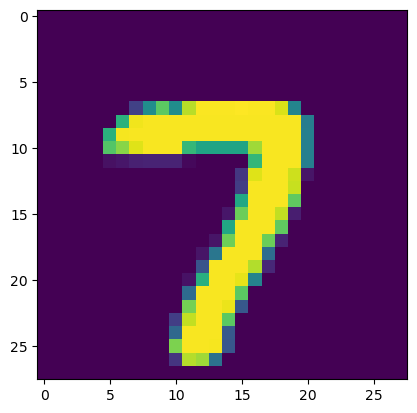

In [4]:
# iter()函数可以将一个可迭代对象转换为一个迭代器
# next()函数可以从迭代器中获取一个批次的数据
imgs, labels = next(iter(train_dl))
# 在pytorch里面图片的表示形式：【batch， channel， hight， width】
# transforms.ToTensor()将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
print(imgs.shape) # [batch, channel, hight, width]
img = imgs[0] # 切片取出一张图片
print(img.shape) # [channel, hight, width]
img = img.numpy() # 将张量转换为numpy数组(ndarray)
img = np.squeeze(img) # 将张量中的维度为1的维度去掉
print(img.shape) # [hight, width]
print(labels[0]) # 打印出图片对应的标签
plt.imshow(img)  # 显示图片

tensor([7, 8, 8, 8, 2, 2, 4, 3, 8, 1])


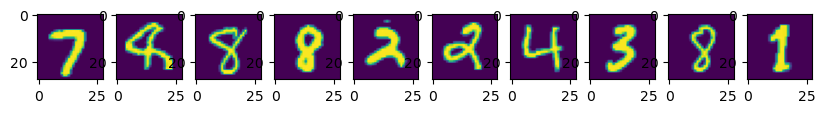

In [5]:
print(labels[:10]) # 打印出前10张图片对应的标签
# 图片显示函数
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)
plt.figure(figsize=(10, 1)) # 创建一个figure画布对象，设置大小为10*1
# 遍历imgs中的前10张图片
for i, img in enumerate(imgs[:10]):
    plt.subplot(1, 10, i+1) # 绘制子图，设置子图的行数为1，列数为10，第i+1个子图
    imshow(img)

## 创建模型

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(28*28, 120)    # 输入层到隐藏层，超参数选择为120
        self.liner_2 = nn.Linear(120, 84)       # 隐藏层到隐藏层，超参数选择为84
        self.liner_3 = nn.Linear(84, 10)        # 隐藏层到输出层，分类数为10
    def forward(self, input):
        x = input.view(-1, 28*28)               # 将输入的图片展平，将channel维度去掉，将hight和width维度合并为一个维度 28*28
        x = F.relu(self.liner_1(x))             # 第一层，激活函数为ReLU
        x = F.relu(self.liner_2(x))             # 第二层，激活函数为ReLU
        x = self.liner_3(x)                     # 输出层，不使用激活函数
        return x

In [7]:
model = Model() # 实例化模型
loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数
opt = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001

In [8]:
# 训练函数，输入模型、训练数据、测试数据，返回loss和acc变化
def fit(epoch, model, trainloader, testloader):
    # 模型训练，记录模型在训练集上的loss和acc
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)    # 按照行取最大值，返回最大值的索引，即预测值
            correct += (y_pred == y).sum().item()   # 计算每个batch中预测正确的数量，并累加到correct变量中得到每个epoch中预测正确的数量
            total += y.size(0)                      # 计算每个batch中样本的数量，并累加到total变量中得到每个epoch中样本的总数
            running_loss += loss.item()             # 计算每个batch中损失，并累加到running_loss变量中得到每个epoch中损失的总和
        
    epoch_loss = running_loss / len(trainloader.dataset)    # 每个epoch中损失的总和除以总样本数，得到每个epoch的平均损失
    epoch_acc = correct / total                             # 计算每个epoch中预测正确的数量占总数的比例，即准确率
        
    # 模型测试，记录模型在测试集上的loss和acc
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in testloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
   '   ', 'loss: ', round(epoch_loss, 3),
   '   ', 'acc:', round(epoch_acc, 3),
   '   ', 'test_loss: ', round(epoch_test_loss, 3),
   '   ', 'test_acc:', round(epoch_test_acc, 3))
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [9]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epochs = 20 # 超参数，训练轮数

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0     loss:  0.005     acc: 0.907     test_loss:  0.001     test_acc: 0.948
epoch:  1     loss:  0.002     acc: 0.958     test_loss:  0.0     test_acc: 0.963
epoch:  2     loss:  0.002     acc: 0.97     test_loss:  0.0     test_acc: 0.969
epoch:  3     loss:  0.001     acc: 0.976     test_loss:  0.0     test_acc: 0.972
epoch:  4     loss:  0.001     acc: 0.982     test_loss:  0.0     test_acc: 0.972
epoch:  5     loss:  0.001     acc: 0.985     test_loss:  0.0     test_acc: 0.974
epoch:  6     loss:  0.001     acc: 0.988     test_loss:  0.0     test_acc: 0.974
epoch:  7     loss:  0.0     acc: 0.99     test_loss:  0.0     test_acc: 0.976
epoch:  8     loss:  0.0     acc: 0.991     test_loss:  0.0     test_acc: 0.973
epoch:  9     loss:  0.0     acc: 0.993     test_loss:  0.0     test_acc: 0.975
epoch:  10     loss:  0.0     acc: 0.994     test_loss:  0.0     test_acc: 0.977
epoch:  11     loss:  0.0     acc: 0.995     test_loss:  0.0     test_acc: 0.977
epoch:  12     loss:  0.